# **Homework 5:** EM and Gibbs sampling
STATS348, UChicago, Spring 2024

----------------
**Your name here:** Daniel Li

----------------

<a href="https://colab.research.google.com/github/aschein/stat_348_2024/blob/main/assignments/hw5/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

The purpose of this homework is to apply the ideas in the last few lectures:
* Bayesian mixture models
* conditional conjugacy
* Gibbs sampling
* EM

Assignment is due **Friday May 10, 11:59pm** on GradeScope.

## Zero-inflated Poisson Mixture Model

The following generative process defines the model we will be working with:
$$
\begin{align}
\boldsymbol{\pi} &\sim \textrm{Dir}(\boldsymbol{\alpha})\\
\omega_{k, d} &\stackrel{\textrm{iid}}{\sim}\textrm{Beta}(a_0, b_0) \\
\lambda_{k, d} &\stackrel{\textrm{iid}}{\sim}\textrm{Gamma}(e_0, f_0) \\
z_i &\stackrel{\textrm{iid}}{\sim} \textrm{Cat}(\boldsymbol{\pi})\\
b_{i,d} &\stackrel{\textrm{ind.}}{\sim} \textrm{Bernoulli}(\omega_{z_i, d}) \\
x_{i,d} &\stackrel{\textrm{ind.}}{\sim} 
\begin{cases}
\delta_0 &\textrm{ if } b_{i,d}=0 \\
\textrm{Pois}(\lambda_{z_i, d}) &\textrm{ if } b_{i,d}=1 \\
\end{cases} 
\end{align}$$

* Each observation is a $D$-dimensional count vector $\boldsymbol{x}_i = (x_{i,1},\dots,x_{i,D}) \in \mathbb{N}_0^D$.

* Each $x_{i,d}$ is associated with a latent Bernoulli variable $b_{i,d}$.  When $b_{i,d}=1$, $x_{i,d}$ is sampled from a Poisson.  When $b_{i,d}=0$, $x_{i,d}=0$ deterministically.

* Each observation is assigned to one of $K$ mixture components $z_i \in \{1,\dots, K\}$.

* We will often use the following transformation of $z_i$
$$
\zeta_{ik} \triangleq \delta(z_i = k),\,\,\boldsymbol{\zeta}_i = (\zeta_{i1},\dots,\zeta_{iK})
$$
* An equivalent way to sample the cluster assignment is:
$$
\boldsymbol{\zeta}_i \sim \textrm{Multinomial}(1, \boldsymbol{\pi})
$$

* Each mixture component $k$ is associated with two $D$-dimensional parameter vectors, $\boldsymbol{\omega}_k$ and $\boldsymbol{\lambda}_k$. 

* The vector $\boldsymbol{\omega}_k = (\omega_{k,1},\dots, \omega_{k,D})$ gives the probabilities for the zero-inflated part of the likelihood; each one $\omega_{k,d} \in (0,1)$ is Beta distributed.

* The vector $\boldsymbol{\lambda}_k = (\lambda_{k,1},\dots, \lambda_{k,D})$ gives the rates for the Poisson part of the likelihood; each one $\lambda_{k,d} > 0 $ is Gamma distributed.

* The weights $\boldsymbol{\pi} \in \Delta_K$ give the prior probability of each component. 

The complete data likelihood of observed $X$ and latent variables $Z$ and $B$ is:
$$
P(X, B, Z \mid \Lambda, \Omega, \boldsymbol{\pi}) = \left[\prod_{i=1}^n P(z_i \mid \boldsymbol{\pi}) \prod_{d=1}^D P(x_{id} \mid b_{id}, \lambda_{z_i, d}) \, P(b_{id} \mid \omega_{z_i, d})\right]$$

The prior over parameters $\Lambda, \Omega, \boldsymbol{\pi}$ is:
$$
P(\Lambda, \Omega, \boldsymbol{\pi}) = P(\boldsymbol{\pi} \mid \boldsymbol{\alpha}) \left[\prod_{k=1}^K \prod_{d=1}^D P(\omega_{k,d} \mid a_0, b_0) \, P(\lambda_{k,d} \mid e_0, f_0)\right]
$$

The following code implements "forward sampling" from the above model. It samples the latent variables from the prior, then the observed variables from the likelihood. The function takes in a dictionary called `hyperparams`, which contains values for the hyperparameters (e.g., $e_0$), and returns two dictionaries---`state` and `data`---which contains values of the latent and observed variables, respectively. We will use these same dictionaries throughout this section, so make sure you understand the code.

In [206]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.special as sp
from tqdm.notebook import tqdm
from copy import deepcopy


def forward_sample(n, D, hyperparams):
    """Generate latent and observed variables from the zero-inflated Poisson mixture model.

    Args:
        n (int): number of data points
        D (int): number of dimensions of each data point
        hyperparams (dict): hyperparameters of the model

    Returns:
        state (dict): dictionary of latent variables
        data (dict): dictionary of observed variables
    """
    a0, b0, e0, f0, alpha_K = [hyperparams[key] for key in ['a0', 'b0', 'e0', 'f0', 'alpha_K']]
    K = alpha_K.size
    
    # sample mixture weights
    pi_K = rn.dirichlet(alpha_K)
    
    # sample component parameters
    omega_KD = rn.beta(a0, b0, size=(K, D))
    lambd_KD = rn.gamma(e0, 1.0/f0, size=(K, D))
    
    # sample assignments (this samples the zeta_ik form of z_i)
    zeta_NK = rn.multinomial(1, pi_K, size=n)
    
    # sample zero-inflated portion
    B_ND = rn.binomial(1, zeta_NK @ omega_KD)
    
    # sample data
    X_ND = B_ND * rn.poisson(zeta_NK @ lambd_KD)

    # define all latent variables as the "state"
    state = {'pi_K': pi_K,
             'omega_KD': omega_KD,
             'lambd_KD': lambd_KD,
             'zeta_NK': zeta_NK,
             'B_ND': B_ND}
    
    # define all observed variables as the "data"
    data = {'X_ND': X_ND}

    return state, data


# Example of usage

K = 3
hyperparams = {'a0': 2.0, 
               'b0': 2.0, 
               'e0': 2.0, 
               'f0': 0.1,
               'alpha_K': np.ones(K)}

state, data = forward_sample(n=1000, D=10, hyperparams=hyperparams)

## Question 1: Complete conditionals [Math] (10pts)

Derive the following complete conditionals.

#### 1a) $P(\boldsymbol{\pi} \mid -) = ?$
___

Your answer here:
$$
P(\boldsymbol{\pi} \mid \boldsymbol{z}) \propto P(\boldsymbol{z} \mid \boldsymbol{\pi}) P(\boldsymbol{\pi}) = \text{Dir}(\boldsymbol{\alpha} + \boldsymbol{n})
$$
where $ \boldsymbol{n} = (n_1, n_2, \ldots, n_K) $ and $ n_k = \sum_{i=1}^n \delta(z_i = k)$.
___

#### 1b) $P(\omega_{k,d} \mid -) = ?$
___

Your answer here: Consider where $ b_{i,d} = 1 $ and $ b_{i,d} = 0 $ for each component $ k $ and dimension $ d $ and let

$ m_{k,d} = \sum_{i: z_i = k} b_{i,d} $ and $ l_{k,d} = \sum_{i: z_i = k} (1 - b_{i,d}) $.

Then by the Beta-Bernoulli conjugacy:

$$
P(\omega_{k,d} \mid -) = \text{Beta}(a_0 + m_{k,d}, b_0 + l_{k,d})
$$


#### 1c) $P(\lambda_{k,d} \mid -) = ?$
___

Your answer here: Consider $ x_{i,d} $ over all such $ i $, let $ s_{k,d} = \sum_{i: z_i = k, b_{i,d} = 1} x_{i,d} $ and count the let number of

 $ x_{i,d} $ sampled under these conditions be $ t_{k,d} $. Then, 
 $$ P(\lambda_{k,d} \mid -) = \text{Gamma}(e_0 + s_{k,d}, f_0 + t_{k,d}) $$

___


## Question 2: Complete conditionals [Code] (10pts)

Here we will implement the complete conditionals for the parameters $\boldsymbol{\pi}, \Omega, \Lambda$. We have implemented the complete conditional for $\boldsymbol{\pi}$ as an example; you will implement those for $\Omega$ and $\Lambda$.

Each of the update functions below takes in the three dictionaries `state`, `data`, `hyperparams`.

Each update function should update the relevant variable in `state` (e.g., `update_pi_K` should update the variable `pi_K`) and then return the modified `state`.

Note that all update functions take `state`, `data`, `hyperparams` as arguments; **do not change this**. Some update functions will not need to access all three, but taking all three dictionaries as arguments will make later code cleaner.

Implement the following functions to sample from the complete conditionals for $\Omega$ and  $\Lambda$.

In [120]:
def update_pi_K(state, data, hyperparams):
    """Update the mixture weights \pi_k. 
    
    This samples pi_K from its complete conditional.
    It then overwrites the current value of pi_K in the state dictionary.
    
    Args:
        state (dict): dictionary of latent variables
        data (dict): dictionary of observed variables
        hyperparams (dict): hyperparameters of the model
    
    Returns:
        state (dict): dictionary of latent variables
    """
    zeta_NK = state['zeta_NK']
    alpha_K = hyperparams['alpha_K']
    state['pi_K'] = rn.dirichlet(alpha_K + zeta_NK.sum(axis=0))
    return state

def update_omega_KD(state, data, hyperparams):
    """Update the component parameters \omega_{k,d}.

    This samples omega_KD from its complete conditional.
    It then overwrites the current value of omega_KD in the state dictionary.

    Args:
        state (dict): dictionary of latent variables
        data (dict): dictionary of observed variables
        hyperparams (dict): hyperparameters of the model
    
    Returns:
        state (dict): dictionary of latent variables
    """
    B_ND = state['B_ND']  
    zeta_NK = state['zeta_NK']  
    a0 = hyperparams['a0']
    b0 = hyperparams['b0']
    K, D = state['omega_KD'].shape
    
    count_1 = np.einsum('nk,nd->kd', zeta_NK, B_ND)  
    count_0 = np.einsum('nk,nd->kd', zeta_NK, 1 - B_ND) 
    state['omega_KD'] = rn.beta(a0 + count_1, b0 + count_0)

    return state

def update_lambd_KD(state, data, hyperparams):
    """Update the component parameters \lambda_{k,d}.

    This samples lambd_KD from its complete conditional.
    It then overwrites the current value of lambd_KD in the state dictionary.

    Args:
        state (dict): dictionary of latent variables
        data (dict): dictionary of observed variables
        hyperparams (dict): hyperparameters of the model
    
    Returns:
        state (dict): dictionary of latent variables
    """
    X_ND = data['X_ND']  
    B_ND = state['B_ND'] 
    zeta_NK = state['zeta_NK'] 
    e0 = hyperparams['e0']
    f0 = hyperparams['f0']
    K, D = state['lambd_KD'].shape
    
    active_lambda_indices = B_ND == 1
    sum_X_NKD = np.einsum('nk,nd,nd->kd', zeta_NK, active_lambda_indices, X_ND) 
    count_X_NKD = np.einsum('nk,nd->kd', zeta_NK, active_lambda_indices) 
    
    state['lambd_KD'] = rn.gamma(e0 + sum_X_NKD, 1 / (f0 + count_X_NKD))

    return state


## Question 3: Complete conditionals [Math] (15pts)

Derive the following complete conditionals.

#### 3a) $P(b_{i,d}=1 \mid -) = ?$
___

Your answer here:

$$
P(b_{i,d} = 1 \mid x_{i,d}, \omega_{z_i,d}, \lambda_{z_i,d}) = \frac{\omega_{z_i,d} \cdot e^{-\lambda_{z_i,d}} \lambda_{z_i,d}^{x_{i,d}} / x_{i,d}!}{\omega_{z_i,d} \cdot e^{-\lambda_{z_i,d}} \lambda_{z_i,d}^{x_{i,d}} / x_{i,d}! + (1-\omega_{z_i,d}) \cdot \delta(x_{i,d}, 0)}
$$

___

#### 3b) $P(z_i=k \mid -) = ?$
___

Your answer here: $$
P(z_i = k \mid \boldsymbol{x}_i, \boldsymbol{b}_i, \Lambda, \Omega) \propto \pi_k \prod_{d=1}^D \left[ P(x_{i,d} \mid z_i = k, b_{i,d}, \lambda_{k,d}) \cdot P(b_{i,d} \mid \omega_{k,d}) \right]$$
And for the equality to hold, we need to normalize the above expression by the sum of the expression over all $ k $.
___

#### 3c) $P(z_i=k \mid -\backslash_{\boldsymbol{b}_i}) = ?$

This questions asks you to derive a "collapsed" complete conditional, where all $b_{i,d}$ variables have been "collapsed" (i.e., marginalized) out.

**Hint:** One way to proceed is to first derive the marginal likelihood $P(x_{i,d} \mid z_i, \Omega, \Lambda)$ with $b_i$ marginalized out, and then derive the complete conditional of $z_i$ based on that.
___

Your answer here: $$
P(z_i = k \mid \boldsymbol{x}_i, \Lambda, \Omega) \propto \pi_k \prod_{d=1}^D \left[ (1-\omega_{k,d}) \delta(x_{i,d}, 0) + \omega_{k,d} e^{-\lambda_{k,d}} \lambda_{k,d}^{x_{i,d}} / x_{i,d}! \right] $$

Again, this must be normalized over all possible $ k $ for the equality to hold.

___



## Question 4: Complete conditionals [Code] (25pts)

Here we will implement the complete conditional for $B$ and the "collapsed" conditional for $Z$.

Both conditionals are discrete distributions that involve products of probabilities. Products of probabilities can be numerically unstable and lead to **underflow errors**.

To avoid underflow, you should work in log-space. The following functions will be useful:
* `scipy.stats.poisson.logpmf`
* `scipy.special.logsumexp`
* `numpy.logaddexp`
* `numpy.log1p`

Moreover, you should also read about the ["log-sum-exp trick"](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/).

We give some examples of how to use these functions below:

In [3]:
import scipy.stats as st
import scipy.special as sp

# for a small probability p, if we want to compute log(1-p), we can use log1p(-p)
# for large p, these are the same
p = 0.5
assert np.allclose(np.log(1-p), np.log1p(-p)) 
# for small p, log(1-p) will underflow
p = 1e-20
assert np.log(1-p) == 0
assert np.log1p(-p) < 0

# for large counts, and small lambda, the product of Poisson PMFs will underflow
# (underflow means that the value will be so small that it will be rounded to zero)
# here is an example:
x = np.ones(10) * 100 
lam = 0.01
assert st.poisson.pmf(x, lam).prod() == 0.0

# by computing the pmf in log space, we can avoid underflow
# (note that the log of 0 would be -inf, so a finite value means we have avoided underflow)
assert np.isfinite(st.poisson.logpmf(x, lam).sum())

# if we want to sum a bunch of small probabilities, we can compute them in log space and then use logsumexp
# this will be more stable than exponentiating the log probabilities first and then summing them
a = st.poisson.logpmf(x, 0.01).sum()
b = st.poisson.logpmf(x, 0.1).sum()
c = st.poisson.logpmf(x, 0.02).sum()
log_sum = sp.logsumexp([a, b, c])
# this is equal to log(exp(a) + exp(b) + exp(c))

# if we just want to sum two probabilities, we can use logaddexp
assert np.logaddexp(a, b) == sp.logsumexp([a, b])

# logsumexp is useful for stable sampling from the multinomial or categorical distributions
# if we want to sample a multinoulli with probabilities proportional to exp(a), exp(b), exp(c)
# we could exponentiate each of the log terms separately, and then normalize them
# however this is numerically unstable and risks underflow; we implement this (bad method) below:

def numerically_unstable_multinoulli(a, b, c):
    # first exponentiate each one
    ea, eb, ec = np.exp(a), np.exp(b), np.exp(c)

    # compute the normalizing constant by summing
    normalizing_constant = ea + eb + ec

    # compute the probabilities by dividing by the normalizing constant
    probs = np.array([ea, eb, ec]) / normalizing_constant

    # sample the multinoulli with these probabilities
    return rn.multinomial(1, probs)

# instead, we can use the logsumexp trick to compute the normalizing constant in log space
# then we can subtract the log normalizing constant from each log probability before exponentiating
# by subtracting a very large negative number (the normalizing constant) from each log probability,
# before exponentiating, we avoid underflow. We implement this (good method) below:

def numerically_stable_multinoulli(a, b, c):
    # compute the log normalizing constant directly using the logsumexp trick
    log_normalizing_constant = sp.logsumexp([a, b, c])

    # compute the log probabilities by subtracting the log normalizing constant
    log_probs = np.array([a, b, c]) - log_normalizing_constant

    # compute the probs by exponentiating the log probs
    probs = np.exp(log_probs)

    # sample the multinoulli with these probabilities
    return rn.multinomial(1, probs)

# try running these two:
# print(numerically_stable_multinoulli(a, b, c))
# print(numerically_unstable_multinoulli(a, b, c))


Now use these functions implement numerically stable versions of `update_B_ND` and `update_zeta_NK` below.

For `update_zeta_NK`, you should **implement the "collapsed" conditional** for $z_i$, using the $\boldsymbol{\zeta}_i$ representation, so that it is sampled from a Multinoulli.

For both functions, we have included the last lines which perform the sampling. 

To implement these functions, you need to write the code that computes the 2d-arrays `P_ND` and `P_NK` in both.

In [208]:
import numpy as np
import numpy.random as rn
from scipy.stats import poisson
from scipy.special import logsumexp

def update_B_ND(state, data, hyperparameters):
    """Update the Bernoulli indicators B_ND using vectorized numpy operations to avoid explicit loops for efficiency.

    Args:
        state (dict): dictionary of latent variables
        data (dict): dictionary of observed variables
        hyperparameters (dict): hyperparameters of the model
    
    Returns:
        state (dict): dictionary of latent variables updated with new values of B_ND
    """
    X_ND = data['X_ND'] 
    omega_KD = state['omega_KD']  
    lambd_KD = state['lambd_KD']  
    zeta_NK = state['zeta_NK']  

    prob_X_given_B1 = poisson.pmf(X_ND[:, None, :], lambd_KD[None, :, :])  
    weighted_prob_X_given_B1 = np.sum(zeta_NK[:, :, None] * omega_KD[None, :, :] * prob_X_given_B1, axis=1)

    is_zero = (X_ND == 0).astype(float)  
    weighted_prob_B0 = np.sum(zeta_NK[:, :, None] * (1 - omega_KD[None, :, :]) * is_zero[:, None, :], axis=1)

    P_B1 = weighted_prob_X_given_B1 / (weighted_prob_X_given_B1 + weighted_prob_B0)

    state['B_ND'] = rn.binomial(1, P_B1)
    return state



def update_zeta_NK(state, data, hyperparams):
    """Update the cluster assignments zeta_NK based on the "collapsed" conditional probabilities using log-space for numerical stability.

    Args:
        state (dict): dictionary of latent variables
        data (dict): dictionary of observed variables
        hyperparams (dict): hyperparameters of the model
    
    Returns:
        state (dict): dictionary of latent variables updated with new values of zeta_NK
    """
    X_ND = data['X_ND']
    omega_KD = state['omega_KD']
    lambd_KD = state['lambd_KD']
    pi_K = state['pi_K']
    n, D = X_ND.shape
    K = pi_K.size

    log_pi_K = np.log(pi_K)
    log_omega = np.log(omega_KD)
    log_1_minus_omega = np.log(1 - omega_KD)
    log_poisson = poisson.logpmf(X_ND[:, None, :], lambd_KD)

    log_prob_zeta = log_pi_K + np.sum(log_poisson + log_omega, axis=2)
    log_prob_zero_inflated = (X_ND[:, None, :] == 0) * log_1_minus_omega
    log_prob_zeta += np.sum(log_prob_zero_inflated, axis=2)

    log_prob_zeta -= logsumexp(log_prob_zeta, axis=1, keepdims=True)

    P_NK = np.exp(log_prob_zeta)
    for i in range(n):
        state['zeta_NK'][i] = rn.multinomial(1, P_NK[i])

    return state




### Defining the Gibbs transition operator

We have implemented the following code that takes your update functions and wraps them into a Gibbs sampler.

Study the code so you understand what it is doing.

In [28]:
def get_gibbs_transition(data, hyperparams):
    """Returns a function that performs a single Gibbs transition
    
    Args:
        data (dict): dictionary containing the observed variables
        hyperparams (dict): dictionary containing the hyperparameters
    
    Returns:
        function: function that performs a single Gibbs transition
    """
    
    update_funcs = {
        'pi_K': update_pi_K,
        'omega_KD': update_omega_KD,
        'lambd_KD': update_lambd_KD,
        'zeta_NK': update_zeta_NK,
        'B_ND': update_B_ND
    }

    def gibbs_transition(state):
        for var in update_funcs.keys():
            state = update_funcs[var](state, data, hyperparams)
        return state

    return gibbs_transition


def gibbs(data, hyperparams, n_samples=250, n_burnin=100, n_thin=5):
    """Gibbs sampler for the Zero-Inflated Poisson Mixture Model

    Args:
        data (dict): dictionary containing the observed variables
        hyperparams (dict): dictionary containing the hyperparameters
        n_samples (int, optional): number of posterior samples to collect. 
        n_burnin (int, optional): number of burn-in samples.
        n_thin (int, optional): thinning parameter. Only collect every n_thin samples.
    
    Returns:
        posterior_samples (list): list of posterior samples, each sample is a state dictionary
    """
    # get the transition operator
    gibbs_transition = get_gibbs_transition(data, hyperparams)

    # initialize the state from the prior
    n, D = data['X_ND'].shape
    state, _ = forward_sample(n, D, hyperparams)
    
    # burn-in samples
    for _ in tqdm(range(n_burnin)):
        state = gibbs_transition(state)
    
    posterior_samples = []
    for s in tqdm(range(n_samples * n_thin)):
        state = gibbs_transition(state)

        # only collect every n_thin samples
        if s % n_thin == 0:
            # make sure to deepcopy so the code does not modify the collected states
            posterior_samples.append(deepcopy(state)) 
    
    return posterior_samples      

### Testing / debugging your code

To debug your code you can use a **Geweke test**. We discussed this in lecture, but you can read more about it in the following references:
 * Grosse's [blogpost](https://lips.cs.princeton.edu/testing-mcmc-code-part-2-integration-tests/)
 * Grosse & Duvenaud (2014) ["Testing MCMC Code"](https://arxiv.org/pdf/1412.5218.pdf)
 * Geweke (2004) ["Getting it right..."](https://www.jstor.org/stable/27590449)

 We have implemented `geweke_test` for you. Study the code to understand what it is doing.

At a high level, the Geweke test generates a set of **forward samples** and set of **backward samples**.

The set of forward samples and backward samples should be equal in distribution if your Gibbs transition operator is correctly implemented.

We will use a visual test to test for equality in distribution. To do this we have also implemented `pp_plot` for you. 

You can read more about a PP plots [here](https://en.wikipedia.org/wiki/P%E2%80%93P_plot).

In [122]:
from pp_plot import pp_plot

def generate_data(state):
    zeta_NK, lambd_KD, B_ND = state['zeta_NK'], state['lambd_KD'], state['B_ND']
    X_ND = B_ND * rn.poisson(zeta_NK @ lambd_KD)
    data = {'X_ND': X_ND}
    return data

def geweke_test(n, D, hyperparams, n_samples=1000, n_burnin=100, n_thin=5):
    """Geweke test for the Zero-Inflated Poisson Mixture Model
    
    Args:
        n (int): number of data points
        D (int): dimensionality of the data
        hyperparams (dict): dictionary containing the hyperparameters
        n_samples (int, optional): number of forward and backward samples to collect.
        n_burnin (int, optional): number of burn-in samples.
        n_thin (int, optional): thinning parameter. Only collect every n_thin samples.
    
    Returns:
        forward_samples (list): list of forward samples, each sample is a state dictionary
        backward_samples (list): list of backward samples, each sample is a state dictionary
    
    References:
        [1] Grosse & Duvenaud (2014) "Testing MCMC Code": https://arxiv.org/pdf/1412.5218.pdf
        [2] Geweke (2004) "Getting it right...": https://www.jstor.org/stable/27590449
    """

    # sample forward from the prior and likelihood
    forward_samples = []
    for _ in tqdm(range(n_samples)):
        state, data = forward_sample(n, D, hyperparams)
        #  we will only collect the states
        forward_samples.append(deepcopy(state))  

    # sample backward using the Gibbs transition operator
    backward_samples = []

    # first initialize with a forward sample of the state, data
    state, data = forward_sample(n, D, hyperparams)

    # the transition operator is defined by data and hyperparams
    gibbs_transition = get_gibbs_transition(data, hyperparams)
    
    # burn-in samples
    for _ in tqdm(range(n_burnin)):
        # perform a single Gibbs transition
        state = gibbs_transition(state)
        # generate data from the new state
        data = generate_data(state)
        # condition on the new data by redefining the transition operator
        gibbs_transition = get_gibbs_transition(data, hyperparams)
    
    for s in tqdm(range(n_samples * n_thin)):
        # perform a single Gibbs transition
        state = gibbs_transition(state)
        # generate data from the new state
        data = generate_data(state)
        # condition on the new data by redefining the transition operator
        gibbs_transition = get_gibbs_transition(data, hyperparams)
        # collect every n_thin sample
        if s % n_thin == 0:
            # we will only collect the states
            backward_samples.append(deepcopy(state))
    
    return forward_samples, backward_samples

## Question 5: Geweke test [Code review, Write] (15pts)

The following code provides an example of how we might use a Geweke test. **Please run this code without modification** so we can assess the correcteness of your implementation.

A Geweke test requires a large number of samples, so running this **may take a few minutes** depending on how efficient your implementation is.

If you are finding that your code is too slow, you can reduce `n_samples`. However, note that your test may appear to fail if `n_samples` is too small.

**Your PP-plots should look like straight lines along the diagonal.**

After running your code, in the space below, provide your own assessment of the results. In particular, what do the three PP-plots say about your implementation of the MCMC transition function. Say whether you believe there is a bug in your code/math, and explain how the PP-plots support that conclusion.

(The points in this question will be fully determined by your textual answer. If there is a bug in your code/math that you cannot track down by the time of submission, you will only lose points on the previous questions.)
___

Your answer here:

The lines look close to the diagonal, which is a good sign that the samples are coming from the same distribution. This suggests that the implementation of the MCMC transition function is correct.
___

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

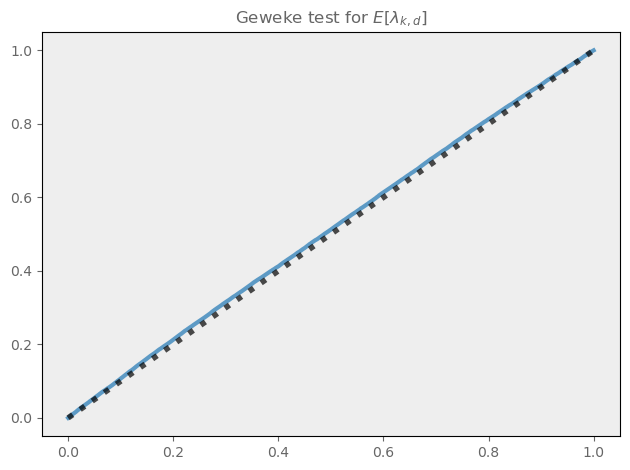

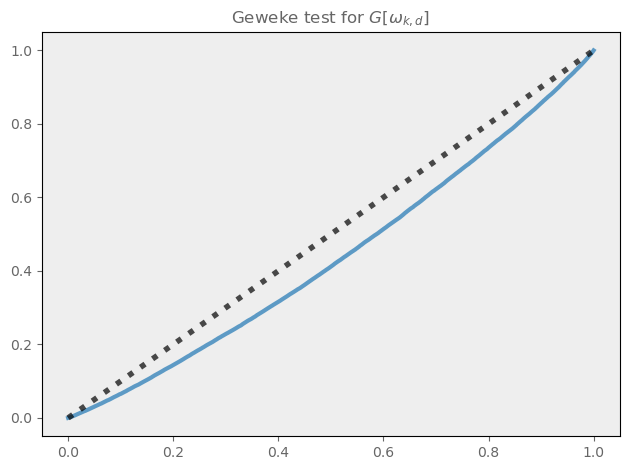

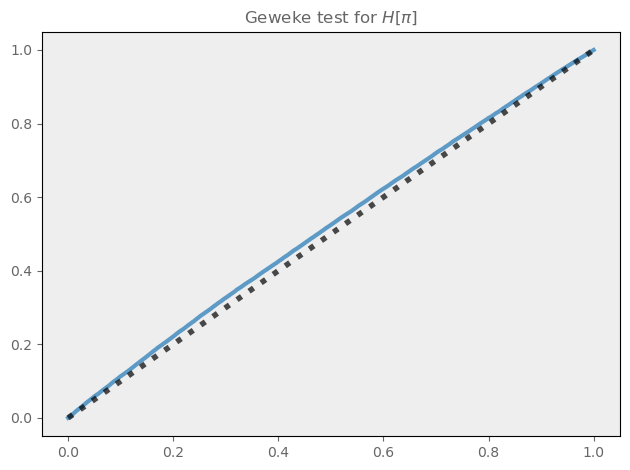

<Figure size 640x480 with 0 Axes>

In [137]:
# You can/should use small n, D, K for the purposes of testing to speed up the code
# Theoretically, your code should pass the Geweke test for any setting of hyperparams.
n = 5
D = 4
K = 3
hyperparams = {'a0': 2.0,
               'b0': 2.0,
               'e0': 2.0,
               'f0': 1.0,
               'alpha_K': np.ones(2)}

forward_samples, backward_samples = geweke_test(n=n, 
                                                D=D, 
                                                hyperparams=hyperparams, 
                                                n_samples=100000, 
                                                n_burnin=10000, 
                                                n_thin=5)

# Compare the arithmetic mean of the lambd_KD parameters across samples
arr1 = [state['lambd_KD'].mean() for state in forward_samples]
arr2 = [state['lambd_KD'].mean() for state in backward_samples]
pp_plot(arr1, arr2, 'Geweke test for $E[\lambda_{k,d}]$')

# Compare the geometric mean of the omega_KD parameters across samples
arr1 = [np.exp(np.mean(np.log(state['omega_KD']))) for state in forward_samples]
arr2 = [np.exp(np.mean(np.log(state['omega_KD']))) for state in backward_samples]
pp_plot(arr1, arr2, 'Geweke test for $G[\omega_{k,d}]$')

# Compare the entropy of the pi vector across samples
arr1 = [st.entropy(state['pi_K']) for state in forward_samples]
arr2 = [st.entropy(state['pi_K']) for state in backward_samples]
pp_plot(arr1, arr2, 'Geweke test for $H[\pi]$')

## Loading "real" (synthetic) data

In the next question, you will run your Gibbs sampler on data we have prepared for you.

First load in the `data` and `hyperparams` dictionaries using `pickle`.

In [58]:
import pickle

with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

with open('hyperparams.pkl', 'rb') as f:
    hyperparams = pickle.load(f)

The data is synthetic and has been generated by the model.

We have re-ordered the rows of the data matrix $X$ so that observations that were part of the same (true) cluster are adjacent. (In a realistic setting, we would not know the true clusters and would not be able to order the matrix in this way.) By doing this, we can explore similarity between observations by glimpsing  "block structure" in the $n \times n$ matrix $X^\top X$, as below:


<Axes: >

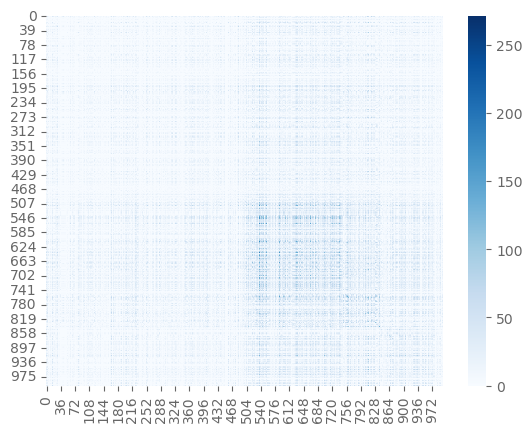

In [146]:
X_ND = data['X_ND']
sns.heatmap(X_ND @ X_ND.T, cmap='Blues')

## Question 6: Results on "real" data [Code] (15pts)
As you can see above, the block structure is very faint. We can instead use our model to get a clearer picture of the similarity between observations.

In this question, you will run the following code which does Gibbs sampling on the data with the provided hyperparameters.

Gibbs sampling will return $S=5,000$ posterior samples of the latent variables $\{\Lambda^s, \Omega^s, \boldsymbol{\pi}^s, Z^s, B^s\}_{s=1}^S$.

Once completed, you will use those samples to compute the following similarity matrix $A \in (0,1)^{n \times n}$, where an entry $A_{ij}$ is an estimate of the following posterior expectation:

$$
A_{ij} = \mathbb{E}\left[z_i = z_j \mid X\right] = \sum_{z_i=1}^K \sum_{z_j=1}^K P(z_i, z_j \mid X)\, \delta(z_i = z_j)
$$
where $P(z_i, z_j \mid X)$ is the posterior over $z_i$ and $z_j$ conditional on the data $X$ (and hyperparameters).

Complete the function `compute_similarity_matrix_gibbs` and then run the two cells. The output should be a heatmap of $A$.

In [204]:
n_samples = 5000
n_burnin = 1000
n_thin = 5

posterior_samples = gibbs(data=data, 
                          hyperparams=hyperparams, 
                          n_samples=n_samples, 
                          n_burnin=n_burnin,
                          n_thin=n_thin)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

<Axes: >

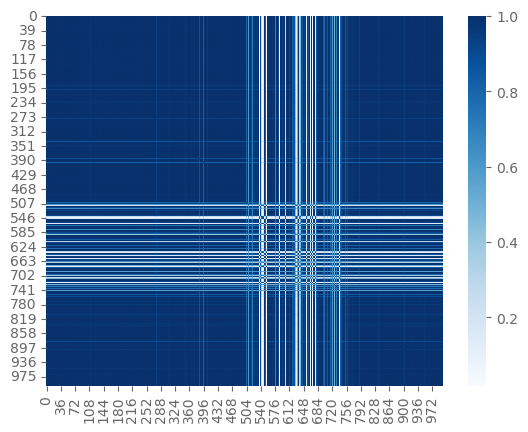

In [205]:


def compute_similarity_matrix_gibbs(posterior_samples):
    """Compute the posterior expectation of the similarity matrix between posterior samples using efficient vectorized operations.
    
    Args:
        posterior_samples (list): list of posterior samples, each sample is a state dictionary
    
    Returns:
        similarity_matrix (np.ndarray): similarity matrix between posterior samples
    """
    n = posterior_samples[0]['zeta_NK'].shape[0] 
    S = len(posterior_samples)  

    A_NN = np.zeros((n, n))

    for sample in posterior_samples:
        zeta_NK = sample['zeta_NK'] 
        A_NN += np.dot(zeta_NK, zeta_NK.T)

    # Normalize by the number of samples to get the probability
    A_NN /= S

    return A_NN


A_NN = compute_similarity_matrix_gibbs(posterior_samples)
sns.heatmap(A_NN, cmap='Blues')

## Part II: The EM algorithm

In this part, we will implement the EM algorithm to do MAP estimation for the parameters $\boldsymbol{\pi}, \Omega, \Lambda$.

The EM algorithm will also provide us with expectations or "beliefs" for the latent variables $Z$ and $B$.

In the E-step, the EM algorithm computes the "beliefs". We will help you by telling you that you will need to compute the following posterior expectations:
$$
\begin{align}
\mathbb{E}_Q[\zeta_{i,k}] \equiv P(z_i =k \mid \boldsymbol{x}_{i}, \boldsymbol{\pi}, \Omega, \Lambda, X) \textrm{ for } i, k
\end{align}
$$

$$
\begin{align}
\mathbb{E}_Q[b_{i,d}]_k \equiv P(b_{i,d}=1 \mid x_{i,d}, z_i=k, \boldsymbol{\pi}, \Omega, \Lambda) \textrm{ for } i, d, k
\end{align}
$$

In the M-step, the EM algorithm maximizes the ELBO with respect to the parameters $\boldsymbol{\pi}, \Omega, \Lambda$. This means
$$
\begin{align}
\boldsymbol{\pi} &\leftarrow \argmax_{\boldsymbol{\pi}} \mathbb{E}_Q\left[\log P(\boldsymbol{\pi} \mid Z, B, X)\right] \\
\Omega &\leftarrow \argmax_{\Omega} \mathbb{E}_Q\left[\log P(\Omega \mid Z, B, X)\right] \\
\Lambda &\leftarrow \argmax_{\Lambda} \mathbb{E}_Q\left[\log P(\Lambda \mid Z, B, X)\right]
\end{align}
$$

Your answers to the complete conditionals in the first part should help to derive the E- and M-steps.


## Question 7: E-step [Math] (15pts)

Derive and provide forms for the beliefs.

___

Your answer here:
$$
\mathbb{E}_Q[\zeta_{i,k}] = \frac{\pi_k \prod_{d=1}^D \left[ (1-\omega_{k,d}) \delta(x_{i,d}, 0) + \omega_{k,d} e^{-\lambda_{k,d}} \lambda_{k,d}^{x_{i,d}} / x_{i,d}! \right]}{\sum_{k'} \pi_{k'} \prod_{d=1}^D \left[ (1-\omega_{k',d}) \delta(x_{i,d}, 0) + \omega_{k',d} e^{-\lambda_{k',d}} \lambda_{k',d}^{x_{i,d}} / x_{i,d}! \right]}
$$
$$
\mathbb{E}_Q[b_{i,d}]_k \equiv P(b_{i,d} = 1 \mid x_{i,d}, z_i = k, \Omega, \Lambda) = \frac{\omega_{k,d} e^{-\lambda_{k,d}} \lambda_{k,d}^{x_{i,d}} / x_{i,d}!}{(1-\omega_{k,d}) \delta(x_{i,d}, 0) + \omega_{k,d} e^{-\lambda_{k,d}} \lambda_{k,d}^{x_{i,d}} / x_{i,d}!}
$$


___

## Question 8: M-step [Math] (15pts)

Derive and provide forms for the M-step updates.

**Hint:** Most common distributions (e.g., Gamma) have closed-form formulas for their mode.

___

Your answer here: 
   $$
   \boldsymbol{\pi}_k \leftarrow \frac{\sum_{i=1}^n \mathbb{E}[\zeta_{i,k}] + \alpha_k - 1}{n + \sum_{k=1}^K (\alpha_k - 1)}
   $$
   $$
   \omega_{k,d} \leftarrow \frac{\alpha_0 -1 + \sum_{i=1}^n \mathbb{E}_Q[\zeta_{i,k}] \cdot \mathbb{E}_Q[b_{i,d}]_k}{\alpha_0 + \beta_0 -2 + \sum_{i=1}^n \mathbb{E}_Q[\zeta_{i,k}]}.
   $$
   $$
   \lambda_{k,d} \leftarrow \frac{e_0 - 1 + \sum_{i=1}^n \mathbb{E}_Q[\zeta_{i,k}] \cdot \mathbb{E}_Q[b_{i,d}]_k \cdot x_{i,d}}{f_0 + \sum_{i=1}^n \mathbb{E}_Q[\zeta_{i,k}] \cdot \mathbb{E}_Q[b_{i,d}]_k}.
   $$

___

## Question 8: Implement EM [Code] (30pts)

Complete the functions `e_step` and `m_step` below using your answers to the previous questions.

You should again work in log-space to avoid numerical issues. It is likely that some of your code from Gibbs sampling can be repurposed.

Both functions take as arguments four dictionaries---`data`, `belief_state`, `params_state`, and `hyperparams`.

These four dictionaries contain the data, the beliefs of latent variables, the parameters, and the hyperparameters.

(You may or may not need to access all four dictionaries in both steps.)

In [209]:

import numpy as np
from scipy.stats import poisson
from scipy.special import logsumexp, expit

def e_step(data, belief_state, params_state, hyperparams):
    X_ND = data['X_ND']
    pi_K = params_state['pi_K']
    omega_KD = params_state['omega_KD']
    lambd_KD = params_state['lambd_KD']
    n, D = X_ND.shape
    K = pi_K.size

    log_prob_X_given_k = np.zeros((n, K))
    for k in range(K):
        log_prob_X_given_k[:, k] = np.sum(poisson.logpmf(X_ND, lambd_KD[k, :]), axis=1)

    log_eta_NK = log_prob_X_given_k + np.log(pi_K + 1e-10)  # Small constant to avoid log(0)

    log_eta_NK -= logsumexp(log_eta_NK, axis=1, keepdims=True)
    Ezeta_NK = np.exp(log_eta_NK)

    Eb_NKD = np.zeros((n, K, D))
    for k in range(K):
        for d in range(D):
            # Safeguard against invalid values in log operations
            safe_omega = np.clip(omega_KD[k, d], 1e-10, 1-1e-10)
            prob_B1_given_X = expit(np.log(safe_omega) - np.log(1 - safe_omega) +
                                    poisson.logpmf(X_ND[:, d], lambd_KD[k, d]) -
                                    np.logaddexp(0, poisson.logpmf(X_ND[:, d], lambd_KD[k, d])))
            Eb_NKD[:, k, d] = prob_B1_given_X

    belief_state['Ezeta_NK'] = Ezeta_NK
    belief_state['Eb_NKD'] = Eb_NKD
    return belief_state


def m_step(data, belief_state, params_state, hyperparams):
    a0, b0, e0, f0, alpha_K = [hyperparams[key] for key in ['a0', 'b0', 'e0', 'f0', 'alpha_K']]
    Ezeta_NK = belief_state['Ezeta_NK']
    Eb_NKD = belief_state['Eb_NKD']
    X_ND = data['X_ND']

    pi_K = (Ezeta_NK.sum(axis=0) + alpha_K - 1) / (Ezeta_NK.sum() + alpha_K.sum() - K)
    
    sum_Eb = Eb_NKD.sum(axis=0)
    sum_Ezeta = Ezeta_NK.sum(axis=0)
    omega_KD = (sum_Eb + a0 - 1) / (sum_Ezeta[:, np.newaxis] + a0 + b0 - 2)

    lambd_KD = (Eb_NKD * X_ND[:, None, :]).sum(axis=0) / Eb_NKD.sum(axis=0)

    params_state['pi_K'] = pi_K
    params_state['omega_KD'] = omega_KD
    params_state['lambd_KD'] = lambd_KD
    return params_state





def initialize_em(data, hyperparams):
    """Initialize the parameters and beliefs for the EM algorithm for the Zero-Inflated Poisson Mixture Model
    
    Args:
        data (dict): dictionary of observed variables
        hyperparams (dict): dictionary of hyperparameters
    
    Returns:
        params_state (dict): dictionary of parameters
        belief_state (dict): dictionary of expectations of latent variables
    """
    n, D = data['X_ND'].shape
    K = hyperparams['alpha_K'].size

    params_state = {}
    params_state['pi_K'] = np.ones(K) / K
    params_state['omega_KD'] = rn.beta(5, 5, size=(K, D))
    params_state['lambd_KD'] = rn.gamma(1, 10, size=(K, D))

    belief_state = {}
    belief_state['Ezeta_NK'] = np.ones((n, K)) / K
    belief_state['Eb_NKD'] = np.ones((n, K, D)) * 0.75
    return params_state, belief_state


def em(data, hyperparams, max_iter=100, tol=1e-8):
    """Run the EM algorithm for the Zero-Inflated Poisson Mixture Model

    Args:
        data (dict): dictionary of observed variables
        hyperparams (dict): dictionary of hyperparameters
        max_iter (int): maximum number of iterations
        tol (float): tolerance for convergence
    """
    params_state, belief_state = initialize_em(data, hyperparams)

    prev_params_state = deepcopy(params_state)
    for _ in tqdm(range(max_iter)):
        belief_state = e_step(data, belief_state, params_state, hyperparams)
        params_state = m_step(data, belief_state, params_state, hyperparams)

        # assess convergence (this can also be done by implementing the ELBO)
        if np.abs(prev_params_state['lambd_KD'] - params_state['lambd_KD']).max() < tol:
            break

        prev_params_state = deepcopy(params_state)
    
    return params_state, belief_state


## Question 9: Results on "real" data [Code] (15pts)

Run the EM algorithm on the data and provided hyperparameters from the first part.

As before, you will also implement a way to visualize the similarity between observations, this time using the beliefs.

An entry in the similarity matrix should equal the following expectation:

$$
A_{ij} = \mathbb{E}\left[z_i = z_j \mid X, \boldsymbol{\pi}^*, \Omega^*, \Lambda^* \right]
$$

where $\boldsymbol{\pi}^*, \Omega^*, \Lambda^*$ are the MAP estimates of the parameters.

Complete the function `compute_similarity_matrix_em` and then run the two cells. The output should be a heatmap of $A$.

In [202]:
params_state, belief_state = em(data, hyperparams, max_iter=1000, tol=1e-8)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

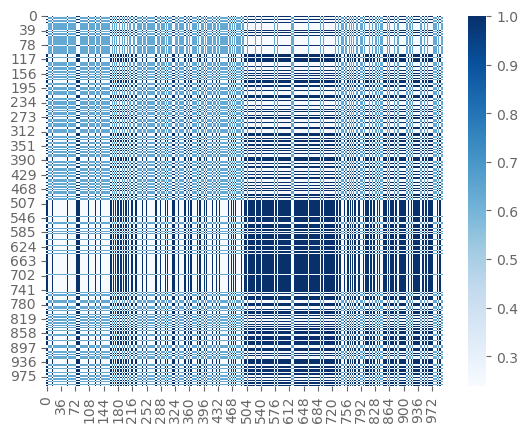

In [210]:


def compute_similarity_matrix_em(params_state, belief_state):
    """Compute the expectation of the similarity matrix given MAP estimates of parameters
    efficiently using matrix multiplication.
    
    Args:
        params_state (dict): dictionary containing the estimated parameters
        belief_state (dict): dictionary containing the beliefs about latent variables (expectations)
    
    Returns:
        similarity_matrix (np.ndarray): similarity matrix between observations
    """
    Ezeta_NK = belief_state['Ezeta_NK']  

    # Compute the similarity matrix using matrix multiplication
    A_NN = np.dot(Ezeta_NK, Ezeta_NK.T)

    return A_NN

A_NN = compute_similarity_matrix_em(params_state, belief_state)

# Plot the similarity matrix using seaborn
sns.heatmap(A_NN, cmap='Blues')
